In [1]:
import os 
os.chdir('../../../../')
print("Current working directory is now: ", os.getcwd())

import pandas as pd 
import numpy as np
import csv
import utils.baseline_functions as base
import stumps
import RiskSLIM as slim

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import roc_auc_score

# restore saved variables
%store -r summary_violent2_KY_interpret

Current working directory is now:  C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test
no stored variable summary_violent2_KY_interpret


C:\Users\binha\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).



### CART & EBM

In [8]:
### load data
data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY data/kentucky_data.csv")
data = data.drop(['fta_risk_score_raw','nca_risk_score_raw','pvf_risk_score_raw', 
                  'fta_calc', 'nca_calc', 'pvf_calc'], axis=1)
x = data.loc[:,:'current_violence']
y = data['recid_violence_two_year'].values

In [9]:
#### CART
depth = [8,9,10]
cart_summary = base.CART(X=x,
                         Y=y,
                         depth=depth,
                         seed=816)

#### EBM
estimators = [20]
depth = [2]
learning_rate = [0.5]
ebm_summary = base.EBM(X=x,
                       Y=y,
                       learning_rate=learning_rate,
                       depth=depth,
                       estimators=estimators,
                       seed =816)

model_id, score_thresholds 0 {'rank_abs': [493]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [467]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [370]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [533]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [506]}
get_disparity_predefined_group()


model_id, score_thresholds 0 {'rank_abs': [383]}
get_disparity_predefined_group()


model_id, score_thresholds 0 {'rank_abs': [412]}
get_disparity_predefined_group()


model_id, score_thresholds 0 {'rank_abs': [400]}
get_disparity_predefined_group()


model_id, score_thresholds 0 {'rank_abs': [397]}
get_disparity_predefined_group()


model_id, score_thresholds 0 {'rank_abs': [377]}
get_disparity_predefined_group()


In [10]:
np.mean(cart_summary['holdout_test_auc']), np.mean(cart_summary['auc_diffs'])

(0.8134264048091857, 0.02058333261467682)

In [11]:
np.mean(ebm_summary['holdout_test_auc']), np.mean(ebm_summary['auc_diffs'])

(0.8202005756793845, 0.004299970992083813)

## Lasso Stumps

In [14]:
## load whole data
data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY data/kentucky_stumps.csv")
X_stumps, Y_stumps = data.loc[:,:'current_violence>=1'], data['recid_violence_two_year'].values
Y_stumps[Y_stumps == -1] = 0
cols = X_stumps.columns[3:]

## load train & test data
train_stumps = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY data/kentucky_train_stumps.csv")
test_stumps = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY data/kentucky_test_stumps.csv")

X_train_stumps, Y_train_stumps = train_stumps.loc[:,:'current_violence>=1'], train_stumps['recid_violence_two_year'].values
X_test_stumps, Y_test_stumps = test_stumps.loc[:,:'current_violence>=1'], test_stumps['recid_violence_two_year'].values

Y_train_stumps[Y_train_stumps == -1] = 0
Y_test_stumps[Y_test_stumps == -1] = 0

#### Nested Cross Validation

In [15]:
stump_summary = stumps.stump_cv(X = X_stumps, 
                                Y = Y_stumps, 
                                columns=cols, 
                                c_grid={'C': [0.007, 0.005, 0.003]}, 
                                seed = 816)

model_id, score_thresholds 0 {'rank_abs': [11540]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [12597]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [12888]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [12356]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [12172]}
get_disparity_predefined_group()


In [16]:
stump_summary['best_params'], np.mean(stump_summary['holdout_test_auc']), np.mean(stump_summary['auc_diffs'])

([{'C': 0.007}, {'C': 0.007}, {'C': 0.007}, {'C': 0.007}, {'C': 0.007}],
 0.8186931345203966,
 0.0010479921745154108)

##### Best Stump Model

In [21]:
best_stump_model = stumps.stump_model(X_train_stumps, Y_train_stumps, 
                                      X_test_stumps, Y_test_stumps, 
                                      c=0.003, columns=cols, seed=816)

##### Prediction Table

In [22]:
stumps.stump_table(best_stump_model['coefs'], 
                   best_stump_model['features'], 
                   best_stump_model['intercept'], 
                   best_stump_model['dictionary'])

+-----------------------------------+----------------+
| Features                          | Score          |
|====================================================|
| sex                               | 46.9           |
| age_at_current_charge<=24         | 11.1           |
| age_at_current_charge<=30         | 1.0            |
| age_at_current_charge<=38         | 11.3           |
| age_at_current_charge<=43         | 0.7            |
| age_at_current_charge<=46         | 6.1            |
| p_arrest>=1                       | -58.1          |
| p_arrest>=2                       | 45.6           |
| p_arrest>=3                       | 21.1           |
| p_arrest>=4                       | 7.4            |
| p_arrest>=5                       | 10.5           |
| p_charges>=1                      | -41.0          |
| p_violence>=1                     | 183.3          |
| p_misdemeanor>=3                  | 6.8            |
| p_weapon>=1                       | 7.1            |
| p_felass

In [23]:
stump_summary = stumps.stump_cv(X = X_stumps, 
                                Y = Y_stumps, 
                                columns=cols, 
                                c_grid={'C': [0.003]}, 
                                seed = 816)

model_id, score_thresholds 0 {'rank_abs': [12312]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [11865]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [12974]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [12002]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [12293]}
get_disparity_predefined_group()


In [24]:
stump_summary['best_params'], np.mean(stump_summary['holdout_test_auc']), np.mean(stump_summary['auc_diffs'])

([{'C': 0.003}, {'C': 0.003}, {'C': 0.003}, {'C': 0.003}, {'C': 0.003}],
 0.8161970524355169,
 0.0006430605673888312)

##### Stumps Visualizations

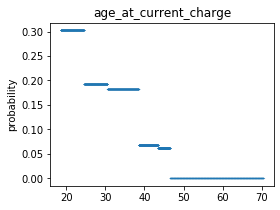

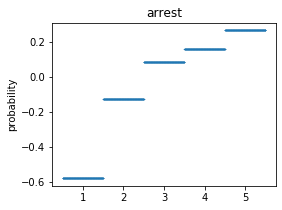

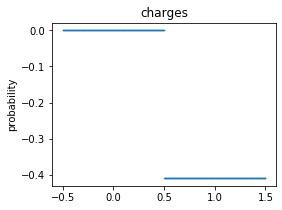

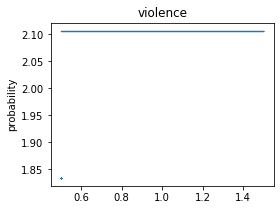

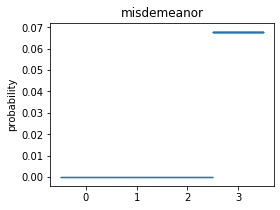

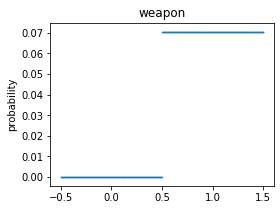

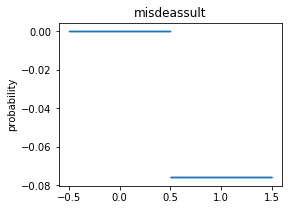

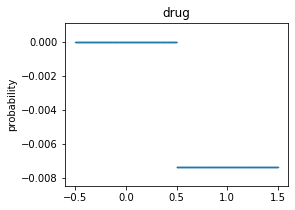

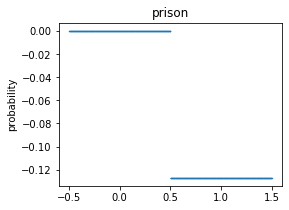

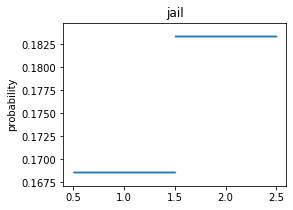

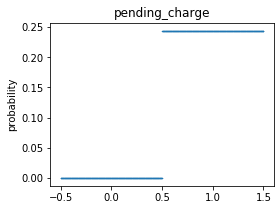

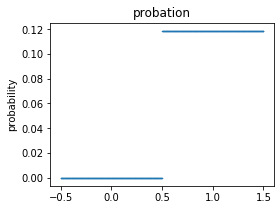

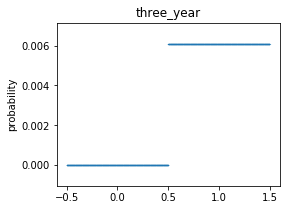

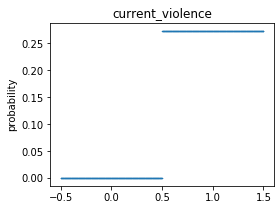

In [25]:
stumps.stump_plots(best_stump_model['features'], best_stump_model['coefs'])

## RiskSLIM

In [40]:
## load stumps data
data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY data/kentucky_stumps.csv")
x, y = data.loc[:,:'current_violence>=1'], data['recid_violence_two_year'].values
cols = x.columns[3:]

In [41]:
## train on best param chosen by Lasso Stumps from above
x_train = x.copy().drop(['race', 'person_id', 'screening_date'], axis=1)
lasso = LogisticRegression(class_weight='balanced', solver='liblinear', penalty='l1', C=0.003, random_state=816).fit(x_train,y)
selected_features = cols[lasso.coef_[0] != 0].tolist()
len(selected_features)

26

In [42]:
### Subset features
if 'sex' in selected_features:
    selected_features = ['recid_violence_two_year', 'person_id', 'screening_date', 'race'] + selected_features
    indicator = 1
else:
    selected_features = ['recid_violence_two_year', 'person_id', 'screening_date', 'race', 'sex'] + selected_features
    indicator = 0

sub_data = data[selected_features]
sub_X, sub_Y = sub_data.iloc[:,1:], sub_data.iloc[:,0].values
sub_X.insert(0, '(Intercept)', 1)

In [43]:
riskslim_summary = slim.risk_cv(X=sub_X, 
                                Y=sub_Y, 
                                indicator = indicator,
                                y_label='recid_violent2', 
                                max_coef=20, 
                                max_coef_number=10, 
                                max_runtime=200, 
                                c=1e-6, 
                                seed=816)

setting c0 = 0.0 to ensure that intercept is not penalized
09/11/19 @ 12:47 AM | 1141 rows in lookup table
09/11/19 @ 12:47 AM | ------------------------------------------------------------
09/11/19 @ 12:47 AM | runnning initialization procedure
09/11/19 @ 12:47 AM | ------------------------------------------------------------
09/11/19 @ 12:47 AM | CPA produced 2 cuts
09/11/19 @ 12:47 AM | running naive rounding on 63 solutions
09/11/19 @ 12:47 AM | best objective value: 0.2013
09/11/19 @ 12:47 AM | rounding produced 5 integer solutions
09/11/19 @ 12:47 AM | best objective value is 0.2102
09/11/19 @ 12:47 AM | running sequential rounding on 63 solutions
09/11/19 @ 12:47 AM | best objective value: 0.2013
09/11/19 @ 12:47 AM | sequential rounding produced 6 integer solutions
09/11/19 @ 12:47 AM | best objective value: 0.2057
09/11/19 @ 12:47 AM | polishing 11 solutions
09/11/19 @ 12:47 AM | best objective value: 0.2057
09/11/19 @ 12:47 AM | polishing produced 5 integer solutions
09/11/19

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
09/11/19 @ 12:47 AM | adding 249 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.2053.
Tried aggregator 1 time.
Reduced MIP has 28 rows, 56 columns, and 107 nonzeros.
Reduced MIP has 26 binaries, 28 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (0.06 ticks)
Probing time = 0.00 sec. (0.02 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variab

 121835 51769        0.2031    13        0.2053        0.2002   762951    2.45%           rho_9 D 121835 121833     31
 124088 52896        0.2002     2        0.2053        0.2002   775746    2.45%          rho_12 U 124088 123904     58
 126254 54258        0.2009     9        0.2053        0.2002   787982    2.45%          rho_25 D 126254 126252     35
 128499 55164        cutoff              0.2053        0.2002   799400    2.45%          rho_15 U 128499 128498     78
 130850 56036        0.2002     9        0.2053        0.2002   811058    2.45%           rho_7 D 130850 130791     82
 133135 56967        cutoff              0.2053        0.2002   822508    2.45%          rho_25 U 133135 133134     49
Elapsed time = 49.76 sec. (50800.78 ticks, tree = 17.50 MB, solutions = 1)
 135537 58243        0.2039     8        0.2053        0.2002   833821    2.45%           rho_0 U 135537 135536     61
 137995 59427        0.2002     5        0.2053        0.2002   845353    2.45%          rho

 344271 141674        0.2044     9        0.2053        0.2002  2347096    2.45%          rho_17 U 344271 344269     50
 351292 144390        0.2031    13        0.2053        0.2002  2396539    2.45%          rho_25 D 351292 351291     53
Elapsed time = 140.88 sec. (168133.28 ticks, tree = 47.79 MB, solutions = 1)
 358453 147570        0.2002     9        0.2053        0.2002  2446344    2.45%           rho_0 D 358453 358451     44
 366348 151173        0.2029     7        0.2053        0.2002  2495693    2.45%          rho_25 D 366348 366346     48
 373384 154386        cutoff              0.2053        0.2002  2545101    2.45%          rho_23 U 373384 373381     64
 379600 156796        0.2012    16        0.2053        0.2002  2597461    2.45%           rho_6 N 379600 379599     30
 385913 159865        0.2042    10        0.2053        0.2002  2650315    2.45%           rho_9 D 385913 385912     76
 392190 162913        0.2023     7        0.2053        0.2002  2703239    2.45%   

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
09/11/19 @ 12:51 AM | adding 249 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.2057.
Tried aggregator 1 time.
Reduced MIP has 28 rows, 56 columns, and 107 nonzeros.
Reduced MIP has 26 binaries, 28 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.06 ticks)
Probing time = 0.00 sec. (0.02 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variab

 110086 49533        cutoff              0.2057        0.2003   684340    2.64%           rho_6 U 110086 110083     65
 111735 50083        0.2042     8        0.2057        0.2003   695898    2.64%           rho_4 U 111735 111734     78
 113291 50541        0.2013     7        0.2057        0.2003   707900    2.64%          rho_24 D 113291 113290     37
 114983 51069        0.2041     6        0.2057        0.2003   719597    2.64%           rho_0 U 114983 114982     17
 116688 51636        cutoff              0.2057        0.2003   731502    2.64%          rho_25 U 116688 116687     71
 118638 52237        cutoff              0.2057        0.2003   741473    2.64%          rho_22 U 118638 118637     51
 120320 52764        0.2003    16        0.2057        0.2003   752674    2.64%          rho_17 D 120320 120319     66
Elapsed time = 48.56 sec. (50804.78 ticks, tree = 16.61 MB, solutions = 2)
 121787 53133        0.2042     8        0.2057        0.2003   765103    2.64%           rh

 286677 131764        0.2032    11        0.2057        0.2003  1997174    2.64%          rho_16 U 286677 286676     95
 291621 134477        0.2011    17        0.2057        0.2003  2036154    2.64%           rho_0 D 291621  23340     14
 297594 137091        cutoff              0.2057        0.2003  2077212    2.64%           rho_0 U 297594 297593     60
Elapsed time = 144.52 sec. (168138.26 ticks, tree = 47.69 MB, solutions = 3)
 303852 139883        0.2003    15        0.2057        0.2003  2120251    2.64%          rho_10 D 303852 303851     86
 310660 142687        0.2028     7        0.2057        0.2003  2159767    2.64%          rho_15 D 310660 310658     61
 317417 145300        0.2040    10        0.2057        0.2003  2198645    2.64%           rho_6 N 317417  86825     27
 322913 147491        cutoff              0.2057        0.2003  2242865    2.64%          rho_21 D 322913 322912     55
 329071 150349        0.2017    13        0.2057        0.2003  2284137    2.64%   

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
09/11/19 @ 12:55 AM | adding 250 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.2070.
Tried aggregator 1 time.
Reduced MIP has 28 rows, 56 columns, and 107 nonzeros.
Reduced MIP has 26 binaries, 28 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.06 ticks)
Probing time = 0.00 sec. (0.02 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variab

 101991 40937        0.2023     9        0.2069        0.2015   584999    2.59%          rho_14 U 101991  81228     62
 104014 41829        0.2024    12        0.2069        0.2015   596328    2.59%           rho_6 D 104014 104013     73
 106064 42782        0.2065    10        0.2069        0.2015   607413    2.59%           rho_0 D 106064 106062     49
 107909 43453        0.2015    10        0.2069        0.2015   618475    2.59%          rho_11 U 107909  33391     23
 109730 43976        0.2045     5        0.2069        0.2015   628930    2.59%           rho_0 U 109730 109729     69
 111616 44611        0.2015     8        0.2069        0.2015   639320    2.59%           rho_8 U 111616  27251     26
 113480 45088        0.2031    14        0.2069        0.2015   649590    2.59%           rho_1 D 113480  13501     22
 115283 46019        0.2015     8        0.2069        0.2015   661561    2.59%          rho_12 U 115283 115281     60
Elapsed time = 43.92 sec. (50806.27 ticks, tree 

 292690 127232        0.2065     7        0.2069        0.2015  1973088    2.59%           rho_0 U 292690 292689     40
 298907 129085        cutoff              0.2069        0.2015  2018455    2.59%          rho_16 U 298907 298906     71
 305298 131277        cutoff              0.2069        0.2015  2060360    2.59%          rho_22 D 305298 305297     58
 312753 133774        0.2052     5        0.2069        0.2015  2094836    2.59%          rho_19 D 312753 312751     73
Elapsed time = 114.55 sec. (168136.45 ticks, tree = 46.41 MB, solutions = 3)
 319228 136674        0.2043    13        0.2069        0.2015  2138949    2.59%           rho_0 N 319228 319226     41
 324899 139739        0.2016    19        0.2069        0.2015  2186149    2.59%           rho_0 D 324899 324897     38
 331051 142620        0.2028    13        0.2069        0.2015  2232066    2.59%           rho_0 U 331051 331050     46
 338390 145477        0.2015     8        0.2069        0.2015  2277688    2.59%   

09/11/19 @ 12:58 AM | best objective value: 0.2057
09/11/19 @ 12:58 AM | ------------------------------------------------------------
09/11/19 @ 12:58 AM | completed initialization procedure
09/11/19 @ 12:58 AM | ------------------------------------------------------------
09/11/19 @ 12:58 AM | 1141 rows in lookup table
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Threads                                 1
CPXPARAM_Parallel                                1
CPXPARAM_RandomSeed                              0
CPXPARAM_TimeLimit                               200
CPXPARAM_MIP_Tolerances_LowerCutoff              0.1999814011805956
CPXPARAM_MIP_Tolerances_UpperCutoff              0.20572843584825332


Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
09/11/19 @ 12:58 AM | adding 249 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.2057.
Tried aggregator 1 time.
Reduced MIP has 28 rows, 56 columns, and 107 nonzeros.
Reduced MIP has 26 binaries, 28 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (0.06 ticks)
Probing time = 0.00 sec. (0.02 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variab

 118730 50163        0.2000     3        0.2050        0.2000   730203    2.44%          rho_12 U 118730 118728     40
 120750 51153        0.2014     9        0.2050        0.2000   744183    2.44%           rho_2 U 120750 120748     37
 122743 51958        0.2036     6        0.2050        0.2000   757776    2.44%           rho_2 U 122743 122741     33
 124715 52601        0.2021     9        0.2050        0.2000   770214    2.44%          rho_19 D 124715 124713     50
 126541 53382        0.2006    11        0.2050        0.2000   784241    2.44%           rho_0 D 126541 126539     99
 128283 54314        0.2006    11        0.2050        0.2000   798233    2.44%           rho_0 U 128283 128282     48
 129987 55217        0.2000     6        0.2050        0.2000   812345    2.44%           rho_0 D 129987 129985     71
 131695 56179        0.2025     6        0.2050        0.2000   824874    2.44%           rho_0 U 131695 131694     45
*132610 56612      integral     0        0.2050 

 292480 124130        0.2038     9        0.2050        0.2000  2036412    2.44%          rho_21 D 292480 292479     82
 297790 126099        cutoff              0.2050        0.2000  2085715    2.44%           rho_3 D 297790 297789     28
 303588 128377        0.2000    11        0.2050        0.2000  2131592    2.44%           rho_0 D 303588 303549     69
 309688 130597        0.2000    12        0.2050        0.2000  2173487    2.44%           rho_0 D 309688 309686     38
 315348 132904        0.2000    11        0.2050        0.2000  2219312    2.44%          rho_12 U 315348 315346     30
 320547 135045        0.2018    15        0.2050        0.2000  2263657    2.44%           rho_2 D 320547 320546     52
 326338 137890        0.2046     7        0.2050        0.2000  2310697    2.44%          rho_25 U 326338 326336     76
Elapsed time = 80.83 sec. (168142.70 ticks, tree = 46.85 MB, solutions = 8)
 331966 140182        0.2000     9        0.2050        0.2000  2357715    2.44%    

 645509 262352        0.2026    12        0.2050        0.2000  4838195    2.44%           rho_9 U 645509 336335     77
 650980 264048        0.2050     8        0.2050        0.2000  4874772    2.44%           rho_2 U 650980 650978     54
 656560 265631        0.2012    13        0.2050        0.2000  4911777    2.44%           rho_6 D 656560 656558     31
Elapsed time = 178.98 sec. (397055.71 ticks, tree = 91.44 MB, solutions = 8)
 661952 267562        0.2013    13        0.2050        0.2000  4952333    2.44%           rho_5 D 661952 661950     37
 666808 269553        0.2005    14        0.2050        0.2000  4996264    2.44%          rho_11 U 666808 624416     73
 671950 271130        0.2037     9        0.2050        0.2000  5037625    2.44%          rho_24 D 671950 671948     42
 677084 272476        0.2019     8        0.2050        0.2000  5078872    2.44%           rho_5 N 677084 538870     49
 682398 274343        0.2047     8        0.2050        0.2000  5117555    2.44%   

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
09/11/19 @ 01:01 AM | adding 250 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.2054.
Tried aggregator 1 time.
Reduced MIP has 28 rows, 56 columns, and 107 nonzeros.
Reduced MIP has 26 binaries, 28 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.06 ticks)
Probing time = 0.00 sec. (0.02 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.02 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variab

 128454 53468        cutoff              0.2054        0.2001   706441    2.56%          rho_16 D 128454 128453     25
 130268 54232        0.2001     8        0.2054        0.2001   717941    2.56%           rho_0 D 130268 130266     72
 132470 55201        0.2001     5        0.2054        0.2001   732754    2.56%          rho_12 U 132470 131761     27
 134400 56439        0.2024    10        0.2054        0.2001   744135    2.56%          rho_19 D 134400 134398     55
 136246 57464        0.2024    13        0.2054        0.2001   754352    2.56%          rho_10 D 136246 136244     63
 138030 58169        0.2001     8        0.2054        0.2001   767297    2.56%           rho_0 D 138030 138028     87
Elapsed time = 27.53 sec. (50802.33 ticks, tree = 17.95 MB, solutions = 1)
 140150 59253        0.2001     9        0.2054        0.2001   783858    2.56%          rho_12 D 140150 140149     41
 142000 60222        0.2001     3        0.2054        0.2001   794184    2.56%          rho

 342627 147838        0.2032    10        0.2054        0.2001  2199422    2.56%          rho_24 U 342627 342524     84
 349743 150825        cutoff              0.2054        0.2001  2239627    2.56%          rho_21 D 349743 349742     64
Elapsed time = 80.55 sec. (168141.27 ticks, tree = 50.58 MB, solutions = 1)
 355361 152961        0.2002    15        0.2054        0.2001  2286456    2.56%          rho_23 D 355361 243747     34
 361573 155462        0.2001    15        0.2054        0.2001  2331770    2.56%          rho_12 D 361573 361572     66
 367721 157946        0.2029    15        0.2054        0.2001  2376686    2.56%           rho_6 D 367721 367720     77
 373830 159968        0.2009    12        0.2054        0.2001  2419098    2.56%          rho_23 U 373830 373783     59
 380031 162305        0.2009    16        0.2054        0.2001  2463179    2.56%           rho_0 D 380031 380029     14
 386580 165283        0.2042     1        0.2054        0.2001  2507766    2.56%    

 723304 301696        0.2036    10        0.2054        0.2001  4986395    2.56%           rho_0 U 723304 723303     69
 728800 303929        0.2033    10        0.2054        0.2001  5027220    2.56%           rho_4 U 728800 728799     42
 734221 306053        0.2007    11        0.2054        0.2001  5068440    2.56%           rho_8 U 734221 734220     83
 739615 308375        0.2007    17        0.2054        0.2001  5109940    2.56%           rho_0 D 739615 265539     52
 745042 310821        cutoff              0.2054        0.2001  5153033    2.56%          rho_11 U 745042 745041     47

User cuts applied:  822

Root node processing (before b&c):
  Real time             =    0.05 sec. (1.20 ticks)
Sequential b&c:
  Real time             =  199.97 sec. (423199.92 ticks)
                          ------------
Total (root+branch&cut) =  200.01 sec. (423201.12 ticks)
+-----------------------------------------------+-------------------+-----------+
| Pr(Y = +1) = 1.0/(1.0 + exp(-(-45 

In [44]:
np.mean(riskslim_summary['train_auc']), np.mean(riskslim_summary['test_auc'])

(0.8007995805356295, 0.8007873753407889)

### Arnold PSA

In [45]:
### load data
data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY data/kentucky_data.csv")
X_arnold_raw = data['pvf_risk_score_raw'].values
X_arnold_calc = data['pvf_calc'].values
Y_arnold = data['recid_violence_two_year'].values

In [46]:
## set up cross validation
cv = KFold(n_splits=5,shuffle=True,random_state=816)
raw_auc = []
calc_auc = []

## raw score
i = 1
for train, test in cv.split(X_arnold_raw, Y_arnold):
    y_pred_raw, y_pred_calc, y_test = X_arnold_raw[test], X_arnold_calc[test], Y_arnold[test]
    raw_auc.append(roc_auc_score(y_test, y_pred_raw))
    calc_auc.append(roc_auc_score(y_test, y_pred_calc))
    i+=1 

### Results

In [47]:
#### save results
summary_general2_KY_interpret = {"CART": cart_summary,
                                   "EBM": ebm_summary, 
                                   'Lasso Stumps': stump_summary, 
                                   'RiskSLIM': riskslim_summary, 
                                   'Arnold PSA Raw': raw_auc, 
                                   'Arnold PSA': calc_auc}
%store summary_general2_KY_interpret

Stored 'summary_general2_KY_interpret' (dict)


In [48]:
results = [["CART", np.mean(cart_summary['holdout_test_auc']), np.mean(cart_summary['auc_diffs'])],
           ["EBM", np.mean(ebm_summary['holdout_test_auc']), np.mean(ebm_summary['auc_diffs'])], 
           ["Lasso Stumps", np.mean(stump_summary['holdout_test_auc']), np.mean(stump_summary['auc_diffs'])],
           ['RiskSLIM', np.mean(riskslim_summary['test_auc'])],
           ['Arnold PSA Raw', round(np.mean(raw_auc), 3)], 
           ['Arnold PSA', round(np.mean(calc_auc), 3)]]
results

[['CART', 0.8134264048091857, 0.02058333261467682],
 ['EBM', 0.8202005756793845, 0.004299970992083813],
 ['Lasso Stumps', 0.8161970524355169, 0.0006430605673888312],
 ['RiskSLIM', 0.8007873753407889],
 ['Arnold PSA Raw', 0.797],
 ['Arnold PSA', 0.796]]

In [49]:
auc = [np.mean(cart_summary['holdout_test_auc']), 
       np.mean(ebm_summary['holdout_test_auc']), 
       np.mean(stump_summary['holdout_test_auc']), 
       np.mean(riskslim_summary['test_auc'])]

In [50]:
path = "C:/Users/binha/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY Results/Models/Two Year/"
results = [["Violent", np.str((round(np.mean(cart_summary['holdout_test_auc']), 3))) + " (" + np.str(round(np.std(cart_summary['holdout_test_auc']), 3)) + ")", 
            np.str(round(np.mean(ebm_summary['holdout_test_auc']),3)) + " (" + np.str(round(np.std(ebm_summary['holdout_test_auc']), 3)) + ")", 
            np.str(round(np.mean(stump_summary['holdout_test_auc']),3)) + " (" + np.str(round(np.std(stump_summary['holdout_test_auc']), 3)) + ")",             
            np.str(round(np.mean(riskslim_summary['test_auc']),3)) + " (" + np.str(round(np.std(riskslim_summary['test_auc']), 3)) + ")", 
            round(np.max(auc) - np.min(auc), 3),
            np.str(round(np.mean(raw_auc), 3)) + " (" + np.str(round(np.std(raw_auc),3)) + ")", 
            np.str(round(np.mean(calc_auc), 3)) + " (" + np.str(round(np.std(calc_auc),3)) + ")"]]
with open(path + 'Interpretable Models Summary.csv', 'a') as writeFile:
    writer = csv.writer(writeFile)
    writer.writerows(results)